# Radio Modulation Classification with FINN - Notebook #1 of 5

## Intro 
Welcome to RadioFINN! Here we will go through 5 notebooks that will show you how to train a model to perform radio modulation 
classification and transform it to run it on the Xilinx ZCU104 fpga! 

### FINN Pipeline Map
Throughout these notebooks you will begin to understand the FINN pipeline! In order the pipeline is:
1. **Dataset and Vanilla model** (you are here)
2. Brevitas Model
3. Transforming Brevitas Model to tidy.onnx
4. Transforming tidy.onnx to bitstream
5. Loading the bitstream on the FPGA!

We are in **1. Dataset and Vanilla model.** This notebook will teach you about the RadioML2021 dataset, and the baseline model architecture that you will use for classifying modulation signals! 

### Overview 
This notebook walks you through 'vanilla' radio modulation classification. In this notebook, we introduce:
1. The RadioML2021 Dataset
2. The PyTorch Dataloader for the dataset
3. A VGG model for classification
4. Training and testing of the model :)
5. Visualizing the model's performance! 



In [1]:
# Import necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import time

# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py
from sklearn.metrics import accuracy_score


In [2]:
# Make sure that CUDA is available - without cuda we would be attempting to run the model on CPU which is tooooo slow. 
assert torch.cuda.is_available(), 'Cuda not available'
gpu = 'cuda'

# 1.1 The RadioML 2021 Dataset <a id='load_dataset'></a>

The dataset comes in hdf5 format and exhibits the following structure:
- 27 modulations
- 26 SNRs per modulation (-20 dB through +30 dB in steps of 2)
- 4096 frames per modulation-SNR combination
- 1024 complex time-series samples per frame
- Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape
- 2,875,392 frames in total
- Value is in int8 [-128, 127]

You can get dataset here:
https://opendata.deepsig.io/datasets/2021.07/RADIOML_2021_07_INT8.tar.gz

In [3]:
# Check if dataset is present
import os.path
dataset_path = "datasets/RADIOML_2021_07_INT8.hdf5"
os.path.isfile(dataset_path)

True

## 1.2 - Dataloader Definition
A pytorch _dataloader_ is an abstraction for a dataset. Simply put, a Pytorch Dataloader organizes the code to load and use the dataset. 

In our case, we define a dataloader for the RADIOML2021 dataset. Specifically, it is here where we define the 27 modulations' names and load the data where each data point has:
1. Raw IQ frame contain 1024 IQ samples (which is INT8)
2. The Frames Modulation ID 
3. The Frames SNR value

We define **3 subsets** of the data, with an 80%-10%-10% split, as our training, validation and test datasets respectively. For each dataset, we ensure there are equal numbers of samples from all (Modulation, SNR) combinations. 

For example, we will have the same number of samples of OOK at SNR 6 as we do 4ASK at SNR 8. 

In [4]:
class radioml_21_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_21_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
        self.num_classes=len(self.mod_classes)
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB, with step of 2 --> 26 snrs

        np.random.seed(2021)

        train_indices = []
        test_indices = []
        val_indices = []

        for mod in range(0, len(self.mod_classes)): # all modulations (0 to 26)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # raw dataset holds frames strictly ordered by modulation and SNR
                # We order the dataset to each mod-snr pair combination for better access of each frame
                # Specifically we divide the dataset into 27 mods group,
                #   and for each group we divide into 26 SNRs,
                # For each modulation-snr pair combination, we have 4096 frames. (27*26*4096 = 2875392)
                # For better analogy, its basically a triple for-loop, with the outer most loop being 27 mods,
                #                                                           then the middle being 26 SNRs,
                #                                                           then inner most being 4096 samples
                # Basically [0[0[0...4095] ...25]...26] with a length of 2875392
                start_idx = 26*4096*mod + 4096*snr_idx 
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                # 80 10 10 split 
                split = int(np.ceil(0.8 * 4096)) 
                split2 = int(np.ceil(0.9 * 4096)) 

                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[:split]
                val_indices_subclass = indices_subclass[split:split2]
                test_indices_subclass = indices_subclass[split2:]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)

                test_indices.extend(test_indices_subclass)
                val_indices.extend(val_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_21_dataset(dataset_path) 

print('Value range: ', np.min(dataset.data),'   ',np.max(dataset.data),'  ',dataset.data.dtype) #The total range of int8 is [-127,128]
print('Total mods: ',dataset.num_classes)
print('Number of SNRs: ',len(dataset.snr_classes))
print('Number of frames per each SNR-Modulation combination: ',dataset.data.shape[0]/(dataset.num_classes*len(dataset.snr_classes)))
print('SNRs: ',dataset.snr_classes,' \n')
print('Total size: ',dataset.data.shape)
print('Training set size: ',len(dataset.train_sampler))
print('Val set size: ',len(dataset.val_sampler))
print('Test set size: ',len(dataset.test_sampler))

Value range:  -112     127    int8
Total mods:  27
Number of SNRs:  26
Number of frames per each SNR-Modulation combination:  4096.0
SNRs:  [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.]  

Total size:  (2875392, 1024, 2)
Training set size:  2300454
Val set size:  287820
Test set size:  287118


## 1.2 Visualize an example frame
In the below cell we select an example frame and plot it. Observe how idx is calculated, this is due to the _original_ organization of the data and _not_ due to how our dataloader works. Our dataloader is used later to train the model, where as here we are interfacing with the original data. 


Modulation: 8FSK, SNR: 30.0 dB, Index: 2871419
Frame shape is (1024, 2)


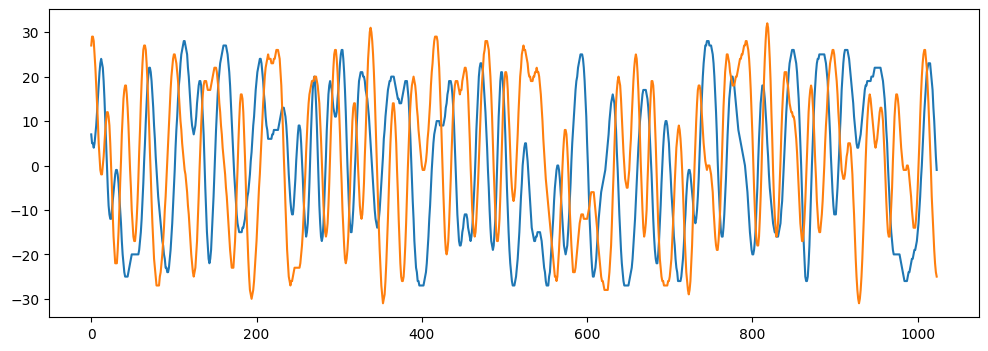

In [5]:
# Inspect a frame
mod = 26 # 0 to 26
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))
print(f"Frame shape is {data.shape}")

# 1.3 VGG model deinfition
We define standard VGG-10 model which is similar Resnet (Used in our lab's other radio modulation work). We use this model specifically because it is compatible with the FINN pipeline. 

The architecure of the model contains:
- 7 Convolutional-1D blocks, 
- 1 Flatten layer,
- 2 Linear blocks 
- 1 final linear layer with an output size of 27 (the classification head)

In [6]:
from torch import nn

# Adjustable hyperparameters
filters_conv = 64
filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class VGG10(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Conv block 1
        self.conv1 = nn.Conv1d(2, filters_conv, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(filters_conv)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)
        
        # Conv block 2
        self.conv2 = nn.Conv1d(filters_conv, filters_conv, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(filters_conv)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)
        
        # Conv block 3
        self.conv3 = nn.Conv1d(filters_conv, filters_conv, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(filters_conv)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2)
        
        # Conv block 4
        self.conv4 = nn.Conv1d(filters_conv, filters_conv, 3, padding=1)
        self.bn4 = nn.BatchNorm1d(filters_conv)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(2)
        
        # Conv block 5
        self.conv5 = nn.Conv1d(filters_conv, filters_conv, 3, padding=1)
        self.bn5 = nn.BatchNorm1d(filters_conv)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool1d(2)
        
        # Conv block 6
        self.conv6 = nn.Conv1d(filters_conv, filters_conv, 3, padding=1)
        self.bn6 = nn.BatchNorm1d(filters_conv)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool1d(2)
        
        # Conv block 7
        self.conv7 = nn.Conv1d(filters_conv, filters_conv, 3, padding=1)
        self.bn7 = nn.BatchNorm1d(filters_conv)
        self.relu7 = nn.ReLU()
        self.pool7 = nn.MaxPool1d(2)
        
        self.flatten = nn.Flatten()
        
        # Dense block 1
        self.fc1 = nn.Linear(filters_conv*8, filters_dense)
        self.bn8 = nn.BatchNorm1d(filters_dense)
        self.relu8 = nn.ReLU()
        
        # Dense block 2
        self.fc2 = nn.Linear(filters_dense, filters_dense)
        self.bn9 = nn.BatchNorm1d(filters_dense)
        self.relu9 = nn.ReLU()
        
        # Output layer
        self.fc3 = nn.Linear(filters_dense, 27, bias=True)

    def forward(self, x):
        # Conv blocks
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu5(self.bn5(self.conv5(x))))
        x = self.pool6(self.relu6(self.bn6(self.conv6(x))))
        x = self.pool7(self.relu7(self.bn7(self.conv7(x))))
        
        x = self.flatten(x)
        
        # Dense blocks
        x = self.relu8(self.bn8(self.fc1(x)))
        x = self.relu9(self.bn9(self.fc2(x)))
        x = self.fc3(x)
        
        return x

model_class = VGG10()
model = model_class

import torchinfo
print(torchinfo.summary(model_class,input_size=(1,2,1024)))

Layer (type:depth-idx)                   Output Shape              Param #
VGG10                                    [1, 27]                   --
├─Conv1d: 1-1                            [1, 64, 1024]             448
├─BatchNorm1d: 1-2                       [1, 64, 1024]             128
├─ReLU: 1-3                              [1, 64, 1024]             --
├─MaxPool1d: 1-4                         [1, 64, 512]              --
├─Conv1d: 1-5                            [1, 64, 512]              12,352
├─BatchNorm1d: 1-6                       [1, 64, 512]              128
├─ReLU: 1-7                              [1, 64, 512]              --
├─MaxPool1d: 1-8                         [1, 64, 256]              --
├─Conv1d: 1-9                            [1, 64, 256]              12,352
├─BatchNorm1d: 1-10                      [1, 64, 256]              128
├─ReLU: 1-11                             [1, 64, 256]              --
├─MaxPool1d: 1-12                        [1, 64, 128]              --
├─C

# 1.4 Train and Test Functions
In the below cell we define the train, test functions, and plot loss functions. It is assumed you have some machine learning background and have a general idea of the process. 

For training, we define the following hyperparameters:
1. **num_epochs** (default=100) which is the number of iterations to train the model for
2. **batch_size** (default=1024) number of sample traces to give to the model each time it predicts
3. **Loss function** is Cross entropy loss
4. **Learning Rate** is 0.01

In [7]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    

    for (inputs, target, snr) in tqdm(train_loader, desc="Training Batches", leave=False):   
        #Converting inputs to float because for some reason torch read inputs as char type
        inputs = inputs.to(gpu).float() 
        target = target.to(gpu)
        
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in tqdm(test_loader, desc="Testing Batches", leave=False):
            inputs = inputs.to(gpu).float()
            target = target.to(gpu)
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

model_name='27ml_rf'
model_file_name='27ml_rf_pytorch_only.pth'

Path(model_name).mkdir(exist_ok=True)
chpt_path=model_name+'/'+model_file_name
print(f'Model parameters will be saved in {chpt_path}')


# HYPER PARAMETERS:
batch_size = 1024
num_epochs = 100
early_stop=10
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)



Model parameters will be saved in 27ml_rf/27ml_rf_pytorch_only.pth


### 1.4 Training Loop
The below cell is our training loop. In this cell we (1) Create the dataloaders (2) Train for either 100 epochs but stop if the validation accuracy does not improves for 10 epochs in a row. 

In [ ]:
# Set up the dataloaders
data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_val = DataLoader(dataset, batch_size=batch_size, sampler=dataset.val_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

#if gpu is not None:
model = model.to(gpu)

running_loss = []
running_test_acc = []
training_time=time.time()
stop_count = 0
best_acc = float('-inf')
for epoch in tqdm(range(num_epochs), desc="Epochs"):
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        val_acc = test(model, data_loader_val)
        print(f"Epoch {epoch}: Training loss = {np.mean(loss_epoch)}, validation accuracy = {val_acc}")
        if val_acc > best_acc: 
            torch.save(model.state_dict(), chpt_path)
            best_acc = val_acc
            print(f'Model checkpoint is saved in {chpt_path}')
            stop_count = 0
        else:
            stop_count+=1
        running_loss.append(loss_epoch)
        running_test_acc.append(val_acc)
        lr_scheduler.step()
        if stop_count >= early_stop:
            break
training_time=time.time()-training_time
print(f'total training time: {training_time}')

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 0: Training loss = 1.507220983505249, validation accuracy = 0.5411680911680912
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 1: Training loss = 1.3078981637954712, validation accuracy = 0.5680633729414217
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 2: Training loss = 1.2604748010635376, validation accuracy = 0.5875894656382461
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 3: Training loss = 1.22416090965271, validation accuracy = 0.5986971023556389
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 4: Training loss = 1.1990267038345337, validation accuracy = 0.6143805156000278
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 5: Training loss = 1.2430977821350098, validation accuracy = 0.5908866652769091


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 6: Training loss = 1.2230243682861328, validation accuracy = 0.6044576471405739


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 7: Training loss = 1.2042875289916992, validation accuracy = 0.6031651726773678


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 8: Training loss = 1.1846989393234253, validation accuracy = 0.6168890278646376
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 9: Training loss = 1.1687073707580566, validation accuracy = 0.6230039608088389
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 10: Training loss = 1.2081621885299683, validation accuracy = 0.608130081300813


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 11: Training loss = 1.1981232166290283, validation accuracy = 0.60218191925509


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 12: Training loss = 1.1840474605560303, validation accuracy = 0.618935445764714


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 13: Training loss = 1.1679840087890625, validation accuracy = 0.6227051629490654


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 14: Training loss = 1.1548117399215698, validation accuracy = 0.6271384893336113
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 15: Training loss = 1.1908150911331177, validation accuracy = 0.6163157529011187


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 16: Training loss = 1.1841496229171753, validation accuracy = 0.6127440761587103


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 17: Training loss = 1.1717983484268188, validation accuracy = 0.6202174970467653


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 18: Training loss = 1.1578450202941895, validation accuracy = 0.6259780418317004


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 19: Training loss = 1.1458051204681396, validation accuracy = 0.6295844625112917
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 20: Training loss = 1.1802979707717896, validation accuracy = 0.615203946911264


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 21: Training loss = 1.17433500289917, validation accuracy = 0.6117886178861789


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 22: Training loss = 1.1638816595077515, validation accuracy = 0.6234313112361893


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 23: Training loss = 1.1505862474441528, validation accuracy = 0.6279132791327914


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 24: Training loss = 1.1393388509750366, validation accuracy = 0.6301229935376277
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 25: Training loss = 1.1718976497650146, validation accuracy = 0.6207977207977208


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 26: Training loss = 1.1668438911437988, validation accuracy = 0.6214821763602252


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 27: Training loss = 1.1574403047561646, validation accuracy = 0.623862136057258


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 28: Training loss = 1.1448554992675781, validation accuracy = 0.6281286915433257


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 29: Training loss = 1.1342546939849854, validation accuracy = 0.6307101660760197
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 30: Training loss = 1.1652854681015015, validation accuracy = 0.6223195052463345


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 31: Training loss = 1.161393404006958, validation accuracy = 0.6237231603085261


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 32: Training loss = 1.1520344018936157, validation accuracy = 0.6223334028212077


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 33: Training loss = 1.1401785612106323, validation accuracy = 0.6296817455354041


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 34: Training loss = 1.1299453973770142, validation accuracy = 0.6311653116531165
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 35: Training loss = 1.1607054471969604, validation accuracy = 0.6218956292127024


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 36: Training loss = 1.156636118888855, validation accuracy = 0.6204746021819193


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 37: Training loss = 1.147798776626587, validation accuracy = 0.6263949690778959


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 38: Training loss = 1.136256217956543, validation accuracy = 0.62944548676256


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 39: Training loss = 1.1262686252593994, validation accuracy = 0.6315509693558474
Model checkpoint is saved in 27ml_rf/27ml_rf_pytorch_only.pth


Training Batches:   0%|          | 0/2247 [00:00<?, ?it/s]

# 1.5 Visualizing the models performance 
Below we create 
1. Loss per epoch plot
2. Accuracy for epoch plot
3. Test on the test dataset
4. Generate a confusion matrix plot for the test dataset 
5. Generate an accuracy plot for the test dataset 

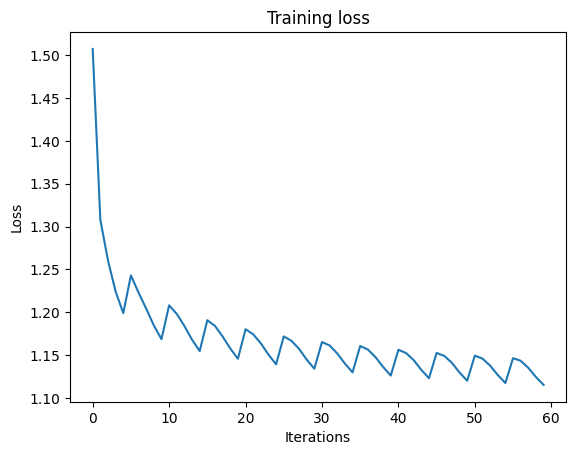

In [16]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

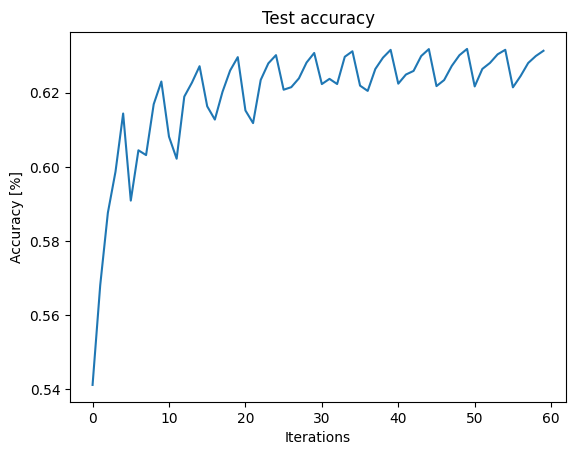

In [17]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

# Evaluate Accuracy

In [18]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_21_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [19]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        #if gpu is not None:
        inputs = inputs.to(gpu).float()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/281 [00:00<?, ?it/s]

## Confusion Matrix across all SNRs

Overall Accuracy across all SNRs: 0.631343


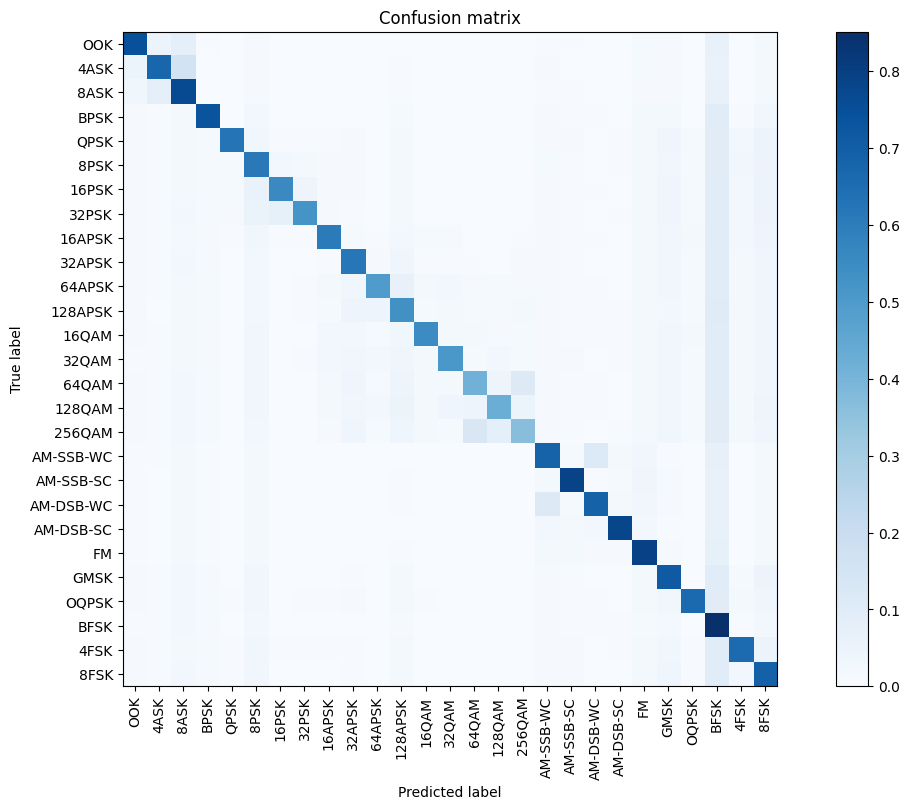

In [20]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

## Confusion Matrix at 4 specific SNRs
Notice how the accuracy is very low at lower SNR and the accuracy is very high at higher SNR

/tmp/ipykernel_119942/3267716818.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221+plot)


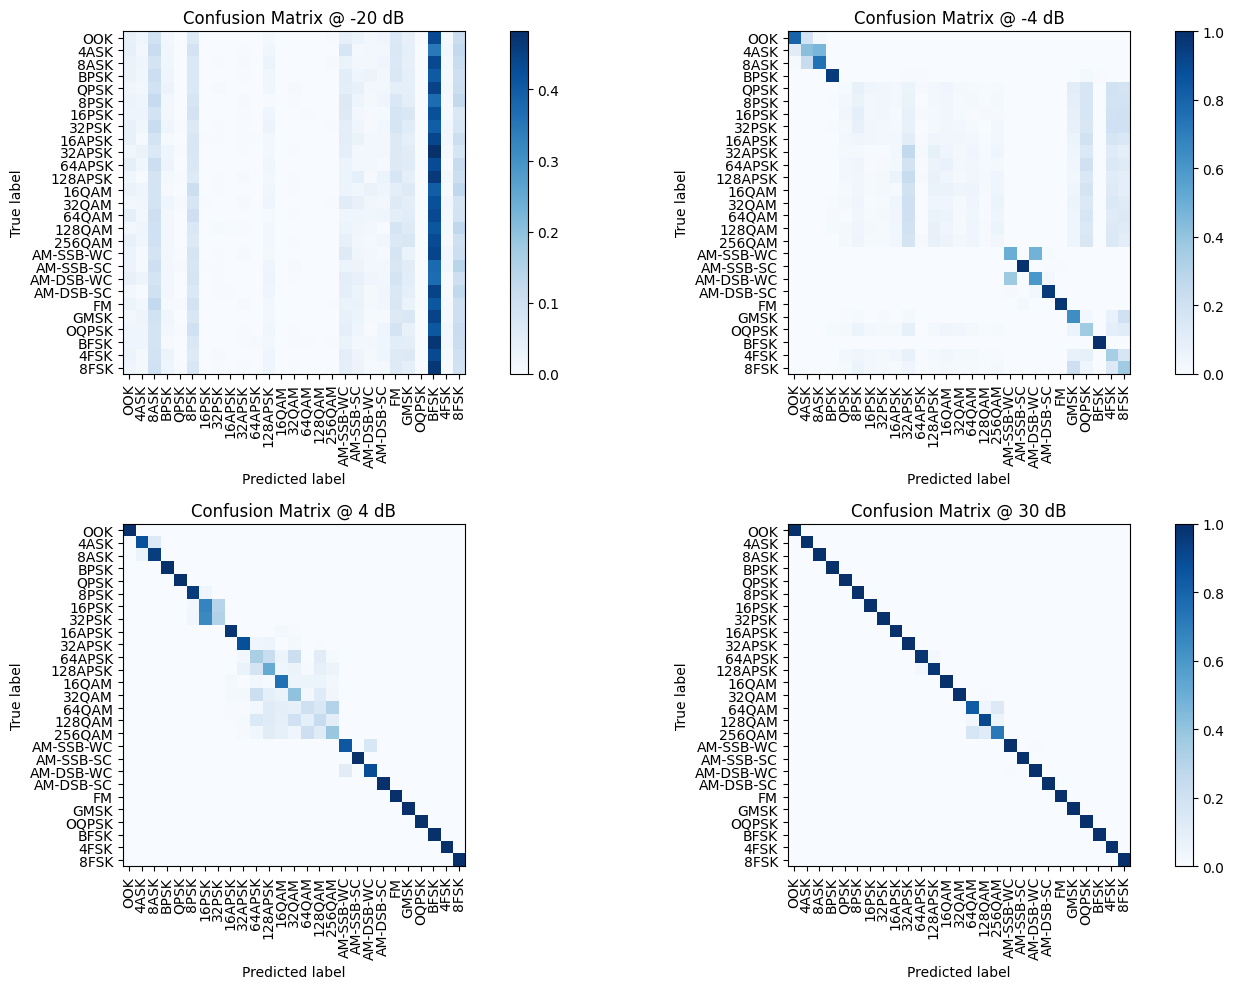

In [21]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

## Accuracy over SNRs

Accuracy @ highest SNR (+30 dB): 0.977180
Accuracy overall: 0.631343
SNR [-20]: 0.040115910531558455
SNR [-18]: 0.039029249298197954
SNR [-16]: 0.04808475957620212
SNR [-14]: 0.05514805759304537
SNR [-12]: 0.08756678438830028
SNR [-10]: 0.1438920583174862
SNR [-8]: 0.21968667934438105
SNR [-6]: 0.29792628814633704
SNR [-4]: 0.3827764194512361
SNR [-2]: 0.49452141628180746
SNR [0]: 0.606538078420719
SNR [2]: 0.6969120709952006
SNR [4]: 0.784931630897401
SNR [6]: 0.8822783663859458
SNR [8]: 0.9379697545956714
SNR [10]: 0.9590690935434212
SNR [12]: 0.9692112650547858
SNR [14]: 0.9712940324187268
SNR [16]: 0.9747351263243684
SNR [18]: 0.9736484650910079
SNR [20]: 0.9721090283437471
SNR [22]: 0.9731051344743277
SNR [24]: 0.975912342660509
SNR [26]: 0.9768178936883093
SNR [28]: 0.9744634610160282
SNR [30]: 0.9771801140994295


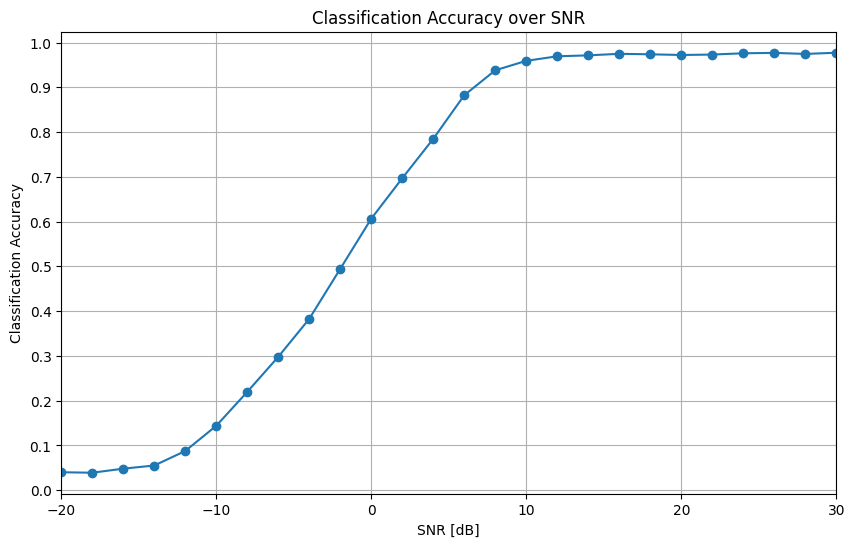

In [23]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))
for i, a in enumerate(acc):
    cur = -20 + 2*i
    print(f"SNR [{-20 + 2*i}]: {a}")

## Breakdown of the accuracy of each modulations over SNRs

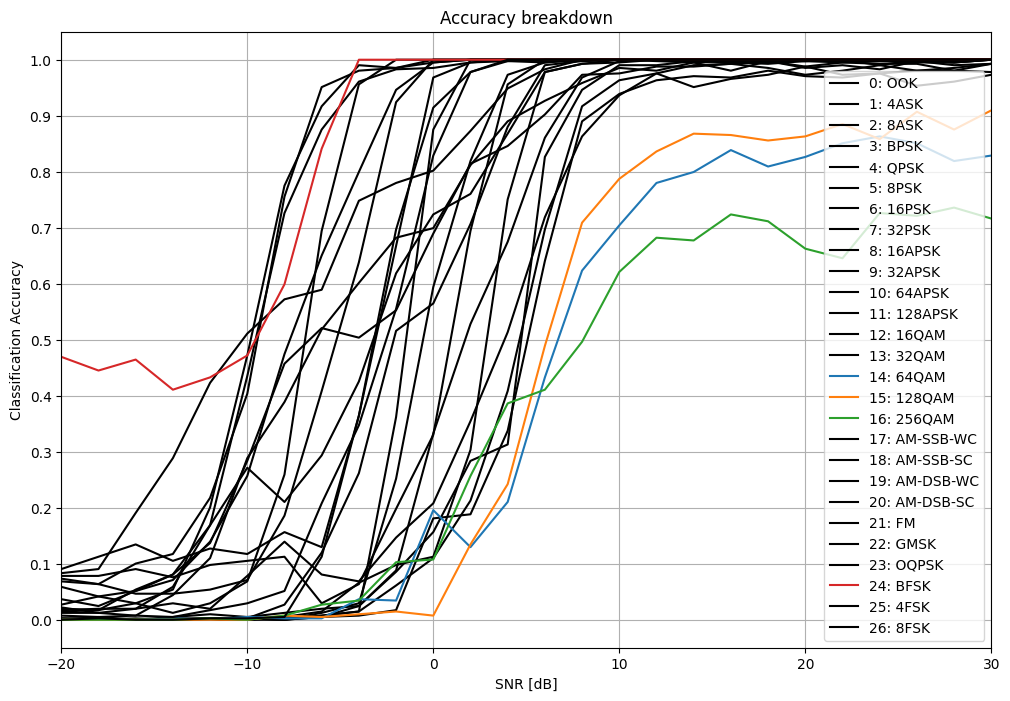

In [24]:
# Plot accuracy per modulation
accs = []
for mod in range((dataset.num_classes)):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(dataset.num_classes):
    if accs[mod][-1] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Accuracy breakdown")
plt.grid()
plt.legend();